In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import csv
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import decomposition
from sklearn.pipeline import Pipeline

import math
from IPython.display import display
import datetime

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential,Model
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dense, Input, Dropout, GaussianDropout, BatchNormalization
from keras.optimizers import Adam, RMSprop, sgd

np.random.seed(seed=1234)


seed=1234
INPUT_SIZE = 331 
nb_classes = 35 # numero di classi 
rows = 2205 # numero di elementi del dataset
bs = 64 #BATCH_SIZE
nb_epoch = 5 # numero di epoche
username = "valentinoperrone"
key = "3babecd7852ce0ee5067bf5683349de8"

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [14]:
!pip install tensorflow==1.14.0


     |████████████████████████████████| 109.2MB 48kB/s 
     |████████████████████████████████| 491kB 43.8MB/s 
     |████████████████████████████████| 3.2MB 42.8MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


**LOAD DATA**

In [0]:
def load_data(): 
 
  #funzione per scaricare i dati da kaggle
  os.environ['KAGGLE_USERNAME'] = username
  os.environ['KAGGLE_KEY'] = key
  !kaggle competitions download -c titanic
  !ls /content
  !unzip titanic

In [0]:
def read_files():
  #leggi righe file train con dataFrame di pandas
  dataset = pd.read_csv("train.csv") 
  # split into input (X) and output (Y) variables
  t = pd.read_csv("test.csv") 
  s = pd.read_csv("gender_submission.csv")
  return dataset,t,s

In [0]:
def data_replace(X):
  #decommenta per riposizionare valori nulli
  #X.fillna(-1, inplace=True)

  # drop the variables we won't be using
  X.drop([ 'Name','PassengerId', 'Ticket','Cabin'], axis=1, inplace=True)

  #trasformo i NaN delle parole con la parola piu frequente
  imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  X[['Sex','Embarked','Pclass']]=imputer.fit(X[['Sex','Embarked','Pclass']]).transform(X[['Sex','Embarked','Pclass']])

  #converti i NaN dei numeri con la media della colonna
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
  X[['Fare','Parch','Age']]=imputer.fit(X[['Fare','Parch','Age']]).transform(X[['Fare','Parch','Age']])


  # CONVERTI TUTTE LE PAROLE IN NUMERI
  X['Sex'] = X['Sex'].astype('category').cat.codes

  # subset all categorical variables which need to be encoded
  categorical = ['Embarked','Pclass']
  #creo colonne per avere variabili 0,1
  for var in categorical:
    X = pd.concat([X,pd.get_dummies(X[var], prefix=var)], axis=1)
    del X[var]


  return X



In [0]:
def standardization(X):
  continuous = ['Age', 'Fare', 'Parch', 'SibSp']

  scaler = StandardScaler()
  X[continuous] = scaler.fit_transform(X[continuous])
  return X
  

In [0]:
def principal_component(X):
  pca = decomposition.PCA(n_components=X.shape[1])
  pca.fit(X)
  pca_score = pca.explained_variance_ratio_
  
  print("Score PCA: \n", pca_score)
  print("\n\n")

  X = pca.transform(X)
  V = pca.components_
  return X



In [0]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0):

    #la lunghezza del vettore lyrs indica il numero dei livelli, il contenuto indica il numero di neuroni ad ogni livello
    #per poter passare il vettore dalla grid, deve essere almeno di 2 elementi, quindi per evitare di avere vettori di 1 elemento ho aggiunto 0


    # set random seed for reproducibility
    np.random.seed(seed=44)

    model = Sequential()
    
     # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=11, activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(rate=dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model
   

In [0]:
def train_model(model,X,Y):
  #early_stopping = EarlyStopping(monitor='val_acc', mode='max',patience=20)
  #baseline è l'errore minimo che voglio raggiungere, per l'accuratezza si usa min_delta=1
  early_stopping = EarlyStopping(monitor='val_loss', mode='min',patience=20, baseline=0.4)

  training = model.fit(X, Y, epochs=50, batch_size=64, validation_split=0.2, verbose=0)
  val_acc = np.mean(training.history['val_acc'])
  print("\n%s: %.2f%%" % ('val_acc', val_acc*100))

  # summarize history for accuracy
  plt.plot(training.history['acc'])
  plt.plot(training.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  # grafici della loss epoca per epoca
  plt.plot(training.history['loss'])
  plt.plot(training.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
def grid_search(X,Y):
  # create model
  #dev essere creato un metodo che crea il modello chiamato create_model()
  model = KerasClassifier(build_fn=create_model, verbose=0)

  # define the grid search parameters
  batch_size = [16, 32, 64]
  epochs = [50, 100]
  param_grid = dict(batch_size=batch_size, epochs=epochs)

  # search the grid
  grid = GridSearchCV(estimator=model, 
                      param_grid=param_grid,
                      cv=3, #NUMERO DEI FOLDS
                      verbose=2)  # include n_jobs=-1 if you are using CPU

  grid_result = grid.fit(X, Y)


  print("Best parameter model: accuracy : %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
 def grid_optimizer(X,Y):
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=64, verbose=0)

  # define the grid search parameters
  optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
  param_grid = dict(opt=optimizer)

  # search the grid
  grid = GridSearchCV(estimator=model, param_grid=param_grid,  cv=3, verbose=2)
  grid_result = grid.fit(X, Y)


  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
def grid_hidden_layer(X,Y):
  np.random.seed(seed=44)

  # create model
  model = KerasClassifier(build_fn=create_model, 
                          epochs=50, batch_size=32, verbose=0)

  # define the grid search parameters
  layers = [(10,5),(12,6),(12,8,4)]
  param_grid = dict(lyrs=layers)

  # search the grid
  grid = GridSearchCV(estimator=model, param_grid=param_grid,   cv=3,verbose=2)
  grid_result = grid.fit(X, Y)

  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
def grid_dropout(X,Y):
  # create model
  model = KerasClassifier(build_fn=create_model, 
                          epochs=50, batch_size=32,  verbose=0)

  # define the grid search parameters
  drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
  param_grid = dict(dr=drops)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
  grid_result = grid.fit(X, Y)
  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))


**PREPROCESSING MAIN**

In [27]:
#run if data not exits
#load_data()
#split in validation
dataset,test, submission=read_files()
Y = dataset.iloc[:,1]
X = dataset.iloc[:,0:12]
X.drop([ 'Survived'], axis=1, inplace=True)

test=data_replace(test)

#mapping male e famale in 0,1
#mapping imbarco su 3 colonne
#remove null value sostituendoli con media o frequenza della parola
#remove name,ticket,cabina
X=data_replace(X)

#standardization
X=standardization(X)
test=standardization(test)

principal_component(X)


Score PCA: 
 [3.13566044e-01 2.42191218e-01 1.37427959e-01 1.11462164e-01
 6.40503481e-02 5.09074881e-02 3.64543061e-02 2.63165060e-02
 1.76239664e-02 4.64874655e-33 1.33072066e-33]





array([[-1.55256916e-02, -9.89001225e-01,  1.06931858e-01, ...,
        -9.10488652e-02, -8.58447439e-17,  1.28590018e-16],
       [ 8.79221199e-02,  1.39511410e+00,  2.68260509e-01, ...,
        -1.79007142e-01,  3.37427784e-16,  1.75677150e-17],
       [-5.70286749e-01, -6.63173102e-01,  2.19580638e-01, ...,
        -2.58472777e-01, -1.69111471e-16,  7.30788663e-17],
       ...,
       [ 1.52389025e+00, -2.84067640e-01, -9.90333935e-01, ...,
        -1.75162204e-01,  1.63955437e-16,  1.75677150e-17],
       [-5.21507216e-01,  3.18739160e-01,  7.93721556e-01, ...,
         6.84469561e-02,  4.48450087e-16, -1.48965739e-16],
       [-8.62494721e-01, -4.08764688e-01, -1.74186103e-02, ...,
         8.19258424e-01,  3.86000042e-16,  7.30788663e-17]])

**TUNING NEURONS FIRST LAYER MAIN**

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 8)                 96        
_________________________________________________________________
dropout_25 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
None


val_acc: 82.37%


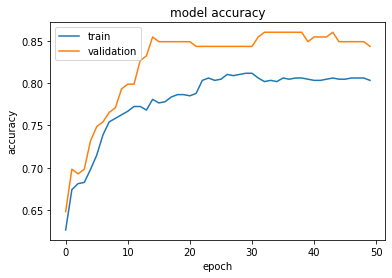

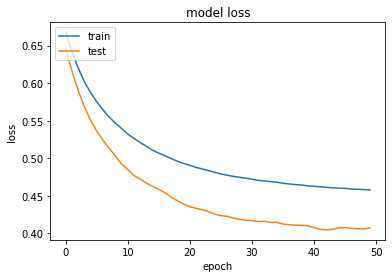

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 10)                120       
_________________________________________________________________
dropout_26 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
None

val_acc: 82.48%


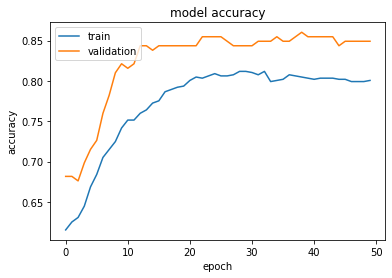

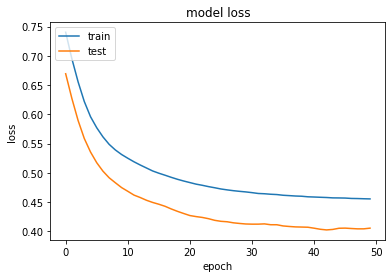

In [28]:
lyrs=[[8],[10]]
display(Y)
#per ognuno dei 10 fold creo il modello e lo fitto, lo faccio due volte ad ogni ciclo per valutare quale neurone è migliore
for i in range(0,len(lyrs)):
  model=create_model(lyrs[i])
  print(model.summary())
  #fit model
  train_model(model,X,Y)

**GRID SEARCH:  PARAMETERS TUNING MAIN**

1.   BATCH SIZE: 16,32,64
2.   EPOCH: 50,10








In [29]:
grid_search(X,Y)  

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] batch_size=16, epochs=50 ........................................
ERROR! Session/line number was not unique in database. History logging moved to new session 62


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... batch_size=16, epochs=50, total=   2.9s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ......................... batch_size=16, epochs=50, total=   2.9s
[CV] batch_size=16, epochs=50 ........................................
[CV] ......................... batch_size=16, epochs=50, total=   2.9s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   5.0s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   5.4s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   5.3s
[CV] batch_size=32, epochs=50 ........................................
[CV] ......................... batch_size=32, epochs=50, total=   2.3s
[CV] batch_size=32, epochs=50 ........................................
[CV] ......................... batch_size=32, epochs=50, total=   2.3s
[CV] batch_size=32, epochs=50 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   58.2s finished


Best parameter model: accuracy : 0.799102 using {'batch_size': 64, 'epochs': 50}
0.791246 (0.011983) with: {'batch_size': 16, 'epochs': 50}
0.794613 (0.009523) with: {'batch_size': 16, 'epochs': 100}
0.792368 (0.006349) with: {'batch_size': 32, 'epochs': 50}
0.793490 (0.012992) with: {'batch_size': 32, 'epochs': 100}
0.799102 (0.016798) with: {'batch_size': 64, 'epochs': 50}
0.794613 (0.009523) with: {'batch_size': 64, 'epochs': 100}


**GRID SEARCH OPTIMIZER TUNING MAIN**

In [30]:
grid_optimizer(X,Y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................................... opt=SGD, total=   2.6s
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] .......................................... opt=SGD, total=   2.6s
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   2.6s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   2.7s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   2.8s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   3.1s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=   2.9s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=   3.0s
[CV] opt=Adagrad .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   56.8s finished


Best: 0.799102 using {'opt': 'Adam'}
0.786756 (0.030157) with: {'opt': 'SGD'}
0.792368 (0.013561) with: {'opt': 'RMSprop'}
0.797980 (0.016722) with: {'opt': 'Adagrad'}
0.796857 (0.011111) with: {'opt': 'Adadelta'}
0.799102 (0.016798) with: {'opt': 'Adam'}
0.792368 (0.011111) with: {'opt': 'Nadam'}


**GRID SEARCH HIDDEN LAYER AND NEURONS TUNING MAIN** 

*   [8],[10],[10,5],[12,6],[12,8,4]
*   la lunghezza del singolo vettore è il numero di layer, il contenuto il numero di neuroni



In [31]:
grid_hidden_layer(X,Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] lyrs=(10, 5) ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................................... lyrs=(10, 5), total=   4.6s
[CV] lyrs=(10, 5) ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ..................................... lyrs=(10, 5), total=   4.7s
[CV] lyrs=(10, 5) ....................................................
[CV] ..................................... lyrs=(10, 5), total=   4.8s
[CV] lyrs=(12, 6) ....................................................
[CV] ..................................... lyrs=(12, 6), total=   4.9s
[CV] lyrs=(12, 6) ....................................................
[CV] ..................................... lyrs=(12, 6), total=   4.9s
[CV] lyrs=(12, 6) ....................................................
[CV] ..................................... lyrs=(12, 6), total=   5.1s
[CV] lyrs=(12, 8, 4) .................................................
[CV] .................................. lyrs=(12, 8, 4), total=   5.6s
[CV] lyrs=(12, 8, 4) .................................................
[CV] .................................. lyrs=(12, 8, 4), total=   5.3s
[CV] lyrs=(12, 8, 4) .................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   45.5s finished


Best: 0.793490 using {'lyrs': (12, 6)}
0.792368 (0.009655) with: {'lyrs': (10, 5)}
0.793490 (0.010408) with: {'lyrs': (12, 6)}
0.793490 (0.011111) with: {'lyrs': (12, 8, 4)}


**GRID DROPOUT MAIN**

*   0.0, 0.01, 0.05, 0.1, 0.2, 0.5



In [32]:
grid_dropout(X,Y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] dr=0.0 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... dr=0.0, total=   5.6s
[CV] dr=0.0 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ........................................... dr=0.0, total=   5.5s
[CV] dr=0.0 ..........................................................
[CV] ........................................... dr=0.0, total=   5.6s
[CV] dr=0.01 .........................................................
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[CV] .......................................... dr=0.01, total=   5.8s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=   5.9s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=   5.9s
[CV] dr=0.05 .........................................................
[CV] .......................................... dr=0.05, total=   6.0s
[CV] dr=0.05 .........................................................
[CV] ............................

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.9min finished


Best: 0.796857 using {'dr': 0.01}
0.792368 (0.006349) with: {'dr': 0.0}
0.796857 (0.022891) with: {'dr': 0.01}
0.793490 (0.022391) with: {'dr': 0.05}
0.790123 (0.026417) with: {'dr': 0.1}
0.786756 (0.024793) with: {'dr': 0.2}
0.773288 (0.024945) with: {'dr': 0.5}


**MODEL CREATION AND FITTING MAIN**

In [33]:
#creazione del modello e training
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []


#per ognuno dei 10 fold creo il modello e lo fitto, lo faccio due volte ad ogni ciclo per valutare quale neurone è migliore
for train, validation in kfold.split(X, Y):
  model=create_model(lyrs=[8], dr=0.1)
  print(model.summary())
  #fit model
  early_stopping = EarlyStopping(monitor='val_loss', mode='min',patience=20, baseline=0.4)
  training = model.fit(X.iloc[train],Y.iloc[train], epochs=50, batch_size=64, validation_split=0.2, verbose=0)
  # evaluate the model
  scores = model.evaluate(X.iloc[validation], Y.iloc[validation], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



display(X.describe(include='all').T)

ERROR! Session/line number was not unique in database. History logging moved to new session 64
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 8)                 96        
_________________________________________________________________
dropout_94 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
None
acc: 79.33%
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 8)                 96        
____________________________________________________

,count,mean,std,min,25%,50%,75%,max
Sex,891.0,6.475870e-01,0.477990,0.000000,0.000000,1.000000,1.000000,1.000000
Age,891.0,2.562796e-16,1.000562,-2.253155,-0.592481,0.000000,0.407926,3.870872
SibSp,891.0,3.456519e-16,1.000562,-0.474545,-0.474545,-0.474545,0.432793,6.784163
Parch,891.0,6.716164e-17,1.000562,-0.473674,-0.473674,-0.473674,-0.473674,6.974147
Fare,891.0,-4.373606e-17,1.000562,-0.648422,-0.489148,-0.357391,-0.024246,9.667167
Embarked_C,891.0,1.885522e-01,0.391372,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,891.0,8.641975e-02,0.281141,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_S,891.0,7.250281e-01,0.446751,0.000000,0.000000,1.000000,1.000000,1.000000
Pclass_1,891.0,2.424242e-01,0.428790,0.000000,0.000000,0.000000,0.000000,1.000000
Pclass_2,891.0,2.065095e-01,0.405028,0.000000,0.000000,0.000000,0.000000,1.000000


**PREDICTION**

In [40]:
# calculate predictions
submission['Survived']=model.predict(test)
#la funzione round prende l'intero superiore, perchè la rete neurale restituisce la probabilità di appartenenza a quella classe
submission['Survived'] = submission['Survived'].apply(lambda x: round(x,0)).astype('int')
solution = submission[['PassengerId', 'Survived']]
display(solution)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


**WRITE ON FILE**

In [0]:
solution.to_csv("Neural_Network_Solution.csv", index=False)